In [1]:
from protofit_wrapper import *
from optimisation_settings import *
from file_reader import *
import matplotlib.pyplot as plt, numpy
mass_1025 = 0.002796
mass_conc = mass_1025*1000/100*1000


# Optimisation

In [2]:
pttwos = [TitrationData('input_data/1025/PC_LIMS_Report-20201026-135736.txt', '200uL_1', 0.10051, 0, mass_1025, -0.1),
          TitrationData('input_data/1025/PC_LIMS_Report-20201026-150929.txt', '200uL_2', 0.10051, 0, mass_1025, -0.1),
          TitrationData('input_data/1025/PC_LIMS_Report-20201026-161307.txt', '200uL_3', 0.100484, 0, mass_1025, -0.1)]

twos = [TitrationData('input_data/1026/PC_LIMS_Report-20201027-133745.txt', '2000uL_1', 0.103476, 0, mass_1025*10, -0.1),
        TitrationData('input_data/1026/PC_LIMS_Report-20201027-143046.txt', '2000uL_2', 0.103632, 0, mass_1025*10, -0.1),
        TitrationData('input_data/1020/PC_LIMS_Report-20201021-201854.txt', '2000uL_3', 0.105585, 0, mass_1025*10, -0.1)]

tens = [TitrationData('input_data/1026/PC_LIMS_Report-20201027-141130.txt', '10000uL_1', 0.11636, 0, mass_1025*50, -0.1),
        TitrationData('input_data/1026/PC_LIMS_Report-20201027-141130.txt', '10000uL_2', 0.119036, 0, mass_1025*50, -0.1),
        TitrationData('input_data/1020/PC_LIMS_Report-20201021-204044.txt', '10000uL_3', 0.116778, 0, mass_1025*50, -0.1)]

concs = [pttwos, twos, tens]
concentration_df = pandas.DataFrame(columns=['sites',
                                             'run_name',
                                             'electrostatic_model',
                                             'lgK1_1',
                                             'lgK2_1',
                                             'lgC_1',
                                             'lgK1_2',
                                             'lgK2_2',
                                             'lgC_2',
                                             'lgK1_3',
                                             'lgK2_3',
                                             'lgC_3',
                                             'lgK1_4',
                                             'lgK2_4',
                                             'lgC_4',
                                             'AICc',
                                             'SSE'])


sites = ["1_acidic", "1_basic", "1_acidic_1_basic", "2_acidic", "2_acidic_1_basic", "3_acidic", "4_acidic"]
sites_names = [sites[i].replace("_"," ") for i in range(len(sites))]

electrostatic_model_numbers = [1, 2, 3, 4]
electrostatic_model_names = ['DLM', 'CCM', 'DSM', 'NEM']

def electrostatic_model_ID(num):
    models = dict(zip(electrostatic_model_numbers, electrostatic_model_names))
    return models[num]


for electrostatic_model in electrostatic_model_numbers:
    for site in sites:
        for conc in concs:
            for data_set in conc:
                data_set.protofit_formatter()
                create_protofit_main_inp(data_set.name, "initial_conditions_" + site + ".xlsx", electrostatic_model=electrostatic_model, SSA=140, DV=1e-6)    
                best_fit = optimise()
                KKC = Results(data_set.name, best_fit)

                n = data_set.nob
                np = KKC.np
                AICc = n*numpy.log(KKC.SSE/n) + 2*(np + 1) + 2*(np + 1)*(np + 2)/(n - np - 2)

                KKC.df[['bacteria_dose','run']] = KKC.df.run_name.str.split("_",expand=True)
                KKC.df.loc[0,'sites'] = site
                KKC.df.loc[0,'SSE'] = KKC.SSE
                KKC.df.loc[0,'AICc'] = AICc
                KKC.df.loc[0, 'electrostatic_model'] = electrostatic_model_ID(electrostatic_model)
                concentration_df = concentration_df.append(KKC.df)

# Finding the higest performing electrostatic model

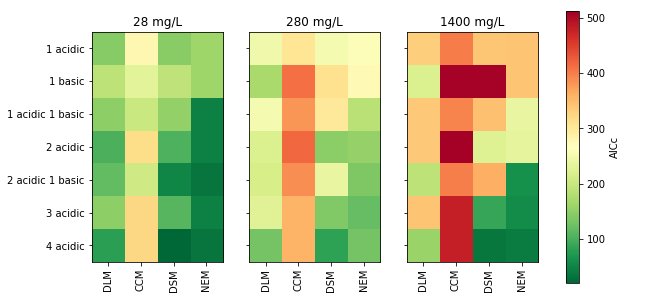

<Figure size 432x288 with 0 Axes>

In [6]:
group_df = concentration_df.groupby(['bacteria_dose', 'electrostatic_model', 'sites'])

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,5))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
doses = ['200uL', '2000uL', '10000uL']
doses_names = [int(numpy.round(mass_conc)), int(numpy.round(mass_conc)*10), int(numpy.round(mass_conc)*50)]
doses_labels = dict(zip(doses, doses_names))

i = 0

for dose in doses:
    heatmap_array = numpy.zeros((7,4))
    row = 0
    for site in sites:   
        col = 0
        for electrostatic_model in electrostatic_model_names:
            heatmap_array[row][col] = group_df.get_group((dose, electrostatic_model, site))['AICc'].mean()
            col += 1
        row += 1
    axes[i].set_yticks(ticks=numpy.arange(len(sites)))
    axes[i].set_yticklabels(sites_names)
    axes[i].set_xticks(numpy.arange(len(electrostatic_model_names)))
    axes[i].set_xticklabels(electrostatic_model_names, rotation=90)
    axes[i].set_title(str(doses_labels[dose]) + " mg/L")
    im = axes[i].imshow(heatmap_array, cmap='RdYlGn_r', vmin=20, vmax=513)
    i += 1
cbar = axes[-1].figure.colorbar(im, ax=axes)
cbar.set_label("AICc", rotation=90)
plt.show()
plt.draw()

In [7]:
fig.savefig('titration_biomass.png', dpi=600)

In [8]:
optimised_esm_sites = concentration_df.loc[(concentration_df['electrostatic_model'] == 'DSM') & 
                     (concentration_df['sites'] == '4_acidic')].groupby('bacteria_dose')

optimised_esm_sites.std()

,lgK1_1,lgK2_1,lgC_1,lgK1_2,lgK2_2,lgC_2,lgK1_3,lgK2_3,lgC_3,lgK1_4,lgK2_4,lgC_4,AICc,SSE
bacteria_dose,,,,,,,,,,,,,,
10000uL,0.015275,0.0,0.017321,0.574485,0.0,0.155885,0.206478,0.0,0.090738,0.525389,0.0,0.049329,132.764855,586.207264
2000uL,0.060828,0.0,0.036056,1.701245,0.0,0.136504,0.189033,0.0,0.098150,0.373140,0.0,0.151438,26.451924,142.272931
200uL,1.017251,0.0,0.316596,0.986120,0.0,0.087369,1.045004,0.0,1.502476,1.025199,0.0,0.795383,49.249617,71.527259
